# SETUP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import warnings
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors

from collections import defaultdict

import json

from tqdm import tqdm
from typing import Any, Dict, Tuple, List, Optional
from collections import Counter

import tensorflow as tf
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score
)

import datetime

plt.rcParams.update({
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "font.size": 14,
    "font.family": "sans-serif",
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    #"axes.spines.top": False,
    #"axes.spines.right": False,
    "legend.frameon": False
    #"axes.grid" : True,
    #"grid.color": "gray",
    #"grid.linestyle": "--",
    #"grid.linewidth": 0.5,
    #"grid.alpha": 0.3,
})

In [3]:
TELESCOPE = {
    "LUVOIR": dict(prefix="B",
                   region_bins={"UV": 8,  "Vis": 94,  "NIR": 49}),
    "HABEX" : dict(prefix="SS",
                   region_bins={"UV": 7,  "Vis":109,  "NIR": 25}),
}

def parse_example(example_proto: tf.Tensor,
                  input_stats: Dict[str, Tuple[float, float]],
                  output_stats: Dict[str, Any],
                  telescope: str = "LUVOIR"):

    meta   = TELESCOPE[telescope]
    pfx    = meta["prefix"]
    bins   = meta["region_bins"]

    # 1) Define raw feature schemas.
    raw_input_features = {f'NOISY_ALBEDO_{pfx}-{r}': tf.io.VarLenFeature(tf.float32)
              for r in ['NIR','UV','Vis']}

    raw_output_features = {
        # Planetary parameters.
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY":           tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE":   tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE":      tf.io.FixedLenFeature([], tf.float32),

        # Chemical abundances.
        'CH4':  tf.io.FixedLenFeature([], tf.float32),
        'CO2':  tf.io.FixedLenFeature([], tf.float32),
        'H2O':  tf.io.FixedLenFeature([], tf.float32),
        'N2':   tf.io.FixedLenFeature([], tf.float32),
        'O2':   tf.io.FixedLenFeature([], tf.float32),
        'O3':   tf.io.FixedLenFeature([], tf.float32),

        'Earth_type': tf.io.FixedLenFeature([], tf.string),
        'OBJECT-STAR-TYPE': tf.io.FixedLenFeature([], tf.string),
        'GEOMETRY-OBS-ALTITUDE': tf.io.FixedLenFeature([], tf.float32),
    }

    # 2) Parse the example.
    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # 3) Normalize input spectra.
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum = parsed[f'NOISY_ALBEDO_{pfx}-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)

        mean = input_stats[region][0]
        std  = input_stats[region][1]
        normalized = (spectrum - mean) / std

        normalized   = tf.reshape(normalized, [bins[region], 1])
        normalized_inputs[f'NOISY_ALBEDO_{pfx}-{region}'] = normalized

    # 4) Process outputs.
    physical_outputs = []
    main_chemical_outputs = []
    other_chemical_outputs = []

    # 4a) Process planetary parameters (physical outputs).
    for param in ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]:
        val = parsed[param]
        # To avoid a very ponctual error we found
        # the floating point precision error generates a single NaN value here :(
        if val == 273.15:
            val += 0.00002
        min_  = output_stats['physical_output_stats'][param][0]
        max_  = output_stats['physical_output_stats'][param][1]
        best_n  = output_stats['physical_output_stats'][param][2]
        processed = (val - min_) / (max_ - min_)
        processed = tf.math.pow(float(processed), float(1/best_n))
        physical_outputs.append(processed)

    # 4b) Process main chemical abundances.
    for chem in ['O2', 'O3']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1/best_n))
        main_chemical_outputs.append(processed)

    # 4c) Process other chemical abundances.
    for chem in ['CH4', 'CO2', 'H2O', 'N2']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1 / best_n))
        other_chemical_outputs.append(processed)

    grouped_outputs = {
        'physical_output': physical_outputs,              # shape (4,)
        'main_chemical_output': main_chemical_outputs,    # shape (2,)
        'other_chemical_output': other_chemical_outputs,  # shape (7,)
        'earth_type': parsed['Earth_type'],
        'star_type': parsed['OBJECT-STAR-TYPE'],
        'obs_altitude': parsed['GEOMETRY-OBS-ALTITUDE'],
    }

    return normalized_inputs, grouped_outputs


def read_tfrecord(file_path: str,
                  telescope: str = "LUVOIR",
                  batch_size: int = 1024,
                  shuffle_buffer: Optional[int] = None,
                  repeat: bool = False):

    meta  = TELESCOPE[telescope]
    pfx   = meta["prefix"]

    with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
        stats = json.load(f)

    # Create lookup dictionaries for input normalization statistics.
    input_stats = {r: (stats['inputs'][f'{pfx}-{r}']['mean'],
                       stats['inputs'][f'{pfx}-{r}']['std'])
                   for r in ['UV','Vis','NIR']}

    physical_keys = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    physical_output_stats = {
        key: (stats['outputs'][key]['min'], stats['outputs'][key]['max'], stats['outputs'][key]['best_n'])
        for key in physical_keys
    }

    chemical_keys = ['CH4', 'CO2', 'H2O', 'N2', 'O2', 'O3']
    chemical_output_stats = {
        key: stats['outputs'][key] for key in chemical_keys
    }

    output_stats: Dict[str, Any] = {
        'physical_output_stats': physical_output_stats,
        'chemical_output_stats': chemical_output_stats
    }

    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset using the parse_example function.
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats, telescope=telescope),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)

    return parsed_dataset

In [4]:
luvoir_ds  = read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/samples.tfrecord", telescope="LUVOIR", batch_size=1)
habex_ds  = read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/samples.tfrecord", telescope="HABEX", batch_size=1)

In [5]:
model_LUVOIR = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/LUVOIR_NEW.keras")
model_HABEX = tf.keras.models.load_model("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/HABEX_NEW.keras")

In [6]:
with open("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json") as f:
    STATS = json.load(f)

def denorm_chem(proc, name):
    n = STATS["outputs"][name]["best_n"]
    return np.asarray(proc) ** n

# CREDIBILITY OF PREDICTIONS

https://ui.adsabs.harvard.edu/abs/2020arXiv201111284H/abstract

In [7]:
def to_log10(arr):
  # this 1e-50 is just to avoid log10(0)
  # but let's discard these cases anyway
  return np.log10(np.maximum(arr, 1e-50))

def harvest(model, dataset, telescope_name):
    rows = []
    for x, y in dataset:
        preds = model(x, training=False)['main_chemical_output'].numpy()
        labs  = y['main_chemical_output'].numpy()

        star  = y['star_type'].numpy().astype(str)
        alt   = y['obs_altitude'].numpy()

        # Iterate over the two target molecules exactly as in Yip+21 Fig. 7.
        for i, mol in enumerate(['O2', 'O3']):
            # De-normalize back to liear mixing ratio
            # then take log10
            y_pred = to_log10(denorm_chem(preds[:, i], mol))
            y_true = to_log10(denorm_chem(labs[:,  i], mol))

            # remove any sample where either value is exactly zero IN LINEAR SPACE
            mask = (denorm_chem(preds[:, i], mol) > 0) & (denorm_chem(labs[:, i], mol) > 0)

            for yp, yt, st, z in zip(y_pred[mask], y_true[mask], star[mask], alt[mask]):
                rows.append(dict(telescope=telescope_name,
                                 mol=mol,
                                 y_pred=yp,
                                 y_true=yt,
                                 star_type=st,
                                 altitude=z))
    return pd.DataFrame(rows)

# 19 MIN
data = pd.concat([
        harvest(model_LUVOIR, luvoir_ds, "LUVOIR"),
        harvest(model_HABEX,  habex_ds,  "HABEX")
])

/tmp/ipython-input-7-1806799964.py:4: RuntimeWarning: divide by zero encountered in log10
  return np.log10(np.maximum(arr, 1e-50))


In [8]:
EPS = 0.5                           # epsion = 0.5 in the paper Yip+21
THOLD = 0.7                         # 1 - delta = 0.7 credibility threashold
BINS = np.arange(-40, 0, 0.5)       # bins centres (our case)
LO, HI = BINS - 0.25, BINS + 0.25   # edges

def credibility(df):
    """
    Returns:
        P : probability that |err| <= 0.5 in each abundance bin.
        N : number of spectra in that bin.
    Mirrors the histogramming algorithm described in Appendix C Yip+21
    """
    P = []; N = []
    for lo, hi in zip(LO, HI):
        sub = df[(df.y_pred >= lo) & (df.y_pred < hi)]
        n = len(sub)

        # Ignore bins with < 20 spectra
        if n < 20:
            P.append(np.nan); N.append(n); continue

        # COre probability P (Y_ture - Y_pred <= epsilon)
        P.append(np.mean(np.abs(sub.y_true - sub.y_pred) <= EPS))
        N.append(n)

    return np.array(P), np.array(N)

In [14]:
STAR_TYPES = ['F', 'G', 'K']
ALT_EDGES = [4, 6, 8, 10, 12, 14, 16, 18, 20]
ALT_LABELS = [f'{lo}–{hi} pc' for lo, hi in zip(ALT_EDGES[:-1], ALT_EDGES[1:])]

In [10]:
def add_altitude_bin(df):
    df = df.copy()
    df['alt_bin'] = pd.cut(df.altitude, ALT_EDGES, labels=ALT_LABELS, right=False)
    return df

In [32]:
COLORS = {'LUVOIR':'tab:gray', 'HABEX':'k'}
TELESCOPE_LABELS = {'LUVOIR': 'LUVOIR-B', 'HABEX': 'HabEx/SS'}
LINE_WIDTH = 1.5
MARKER = 'o'

def draw_line(ax, centres, heights, color, label):
    ax.plot(centres, heights,
            color=color, linewidth=LINE_WIDTH,
            marker=MARKER, markersize=4,
            label=label)

def make_grid(df, slice_key, slice_order, title_fmt, outfile):
    fig, axes = plt.subplots(len(slice_order), 2,
                             figsize=(7, 2 * len(slice_order)),
                             sharey=True, sharex="col",
                             gridspec_kw={'wspace': 0.03, 'hspace': 0.1})

    for row, slice_val in enumerate(slice_order):
        for col, mol in enumerate(['O2', 'O3']):

            ax = axes[row, col]

            for tel in ['LUVOIR', 'HABEX']:
                sub = df[(df.mol == mol) &
                         (df.telescope == tel) &
                         (df[slice_key] == slice_val)]

                P, _ = credibility(sub)  # vetor com P por bin
                tel_label = TELESCOPE_LABELS[tel]
                label = f"{tel_label}" if col == 0 and row == 0 else None
                draw_line(ax, BINS, P, COLORS[tel], label)

            ax.axhline(THOLD, ls='--', color='tab:red', lw=1.5)

            if col == 0:
                ax.set_ylabel(f'{slice_val}\nP(|err| $\leq$ 0.5)')
            if row == len(slice_order) - 1:
                mol_label = r"$\mathrm{O}_2$" if mol == "O2" else r"$\mathrm{O}_3$"
                ax.set_xlabel(rf'predicted log {mol_label}')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, loc='lower center', bbox_to_anchor=(0.5, 0.05))

    fig.savefig(outfile, bbox_inches='tight')
    plt.show()

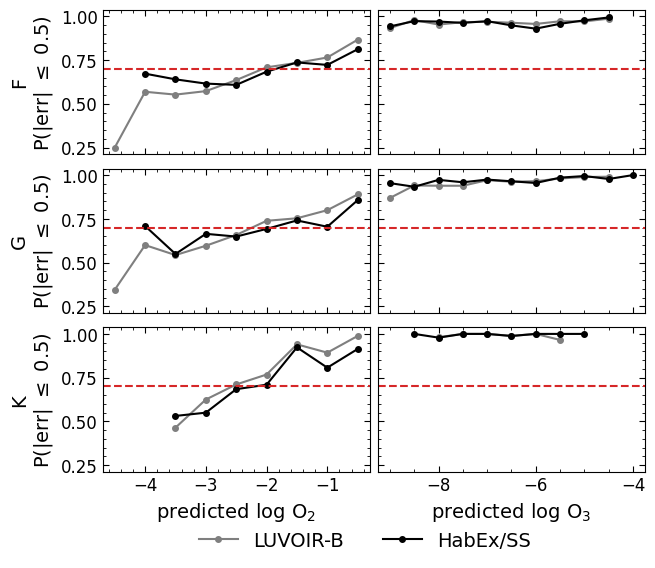

In [31]:
make_grid(
    data,
    slice_key='star_type',
    slice_order=['F','G','K'],
    title_fmt='{mol}',
    outfile='cred_startype.pdf'
)

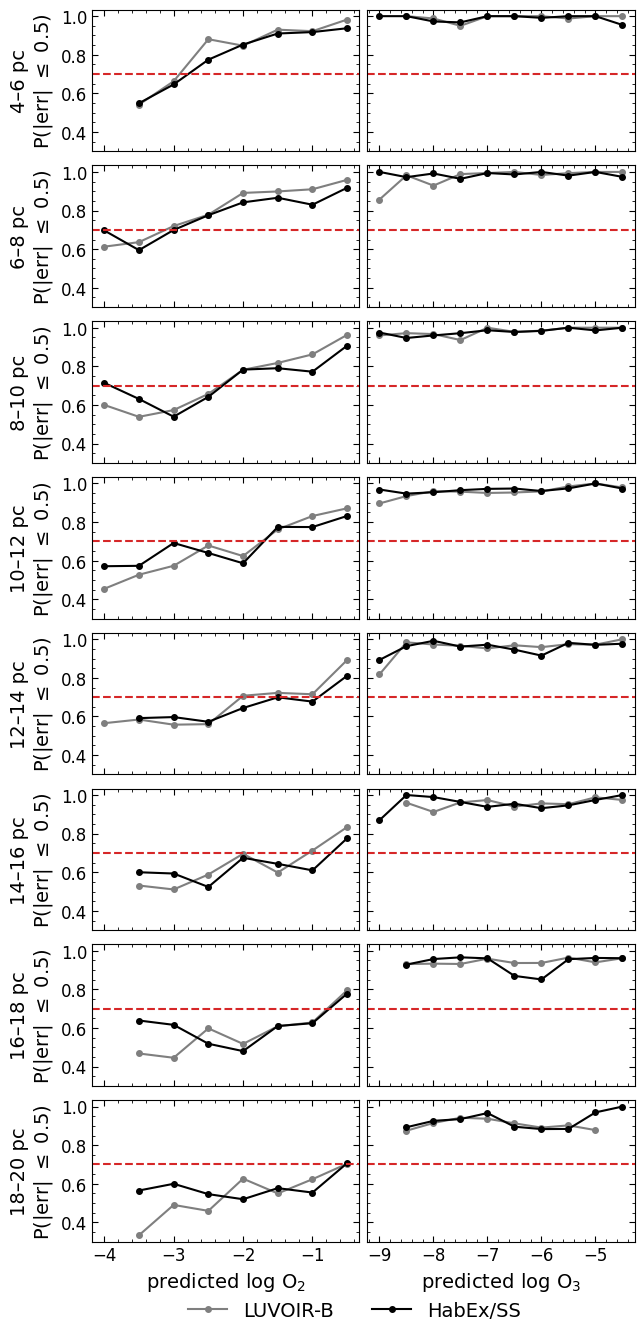

In [33]:
df_alt = add_altitude_bin(data)
make_grid(
    df_alt,
    slice_key='alt_bin',
    slice_order=ALT_LABELS,
    title_fmt='{mol}',
    outfile='cred_distance.pdf'
)